# Study of Common XAI Algos in the Literature

In [8]:
import pandas as pd
import numpy as np
import matplotlib.patheffects as pe
import lime
import os
import time

from data.DatasetLoader import Dataset
from Constants import Constants
from learning.Learner import Learner
from learning.BayesianNet import BayesianNet
import util.aux_functions as util



import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.cm as cm
import matplotlib.image as mpimg
import seaborn as sns

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as expl

from IPython.display import display, HTML, Latex, Image

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

import shap
shap.initjs()

SMALL_SIZE = 6
MEDIUM_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rcParams['figure.dpi']=110

sns.set_style("white")
sns.set()

# Case #1: Linear Function. Data Generated from a Common Effect Structure with Independent Vars

Data generation process is given by
$$ y(x_0,x_1,x_2) = \frac{1}{1+exp(-(2x_0 - x_1))} $$
where...
$$ X \sim \mathcal{N}(0,1) ~~~~~ x_0 \perp \!\!\! \perp x_1 \perp \!\!\! \perp x_2 ~~~~~  y(x_0,x_1,x_2) \perp \!\!\! \perp x_2 $$



## Analyse dataset

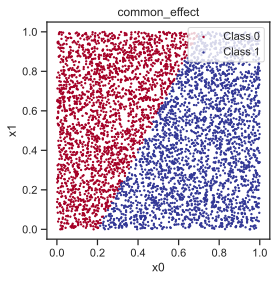

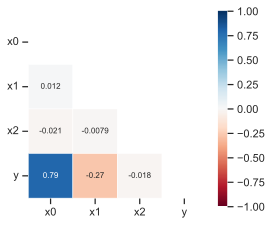

In [19]:
dataset_name = "common_effect"
vars = Constants( dataset_name )
data_common_effect = Dataset( dataset_name, vars.DATASET_PATH,"$$y(x_0, x_1, x_2) = \| 3x_0 - x_1 \|$$", "y")

data_common_effect.visualize_data2D()
data_common_effect.correlation_matrix(text_size=8)

## Bayesian Network Classifiers

G <!-- y --> y y <!-- x1 --> x1 x1 <!-- x1->y --> x1->y <!-- x2 --> x2 x2 <!-- x0 --> x0 x0 <!-- x0->y --> x0->y GHC,G <!-- y --> y y <!-- x1 --> x1 x1 <!-- y->x1 --> y->x1 <!-- x2 --> x2 x2 <!-- y->x2 --> y->x2 <!-- x0 --> x0 x0 <!-- y->x0 --> y->x0 NaiveBayes,G <!-- y --> y y <!-- x1 --> x1 x1 <!-- y->x1 --> y->x1 <!-- x0 --> x0 x0 <!-- y->x0 --> y->x0 <!-- x2 --> x2 x2 <!-- x1->x2 --> x1->x2 Chow-Liu,G <!-- y --> y y <!-- x1 --> x1 x1 <!-- y->x1 --> y->x1 <!-- x0 --> x0 x0 <!-- y->x0 --> y->x0 <!-- x2 --> x2 x2 <!-- x0->x1 --> x0->x1 Tabu


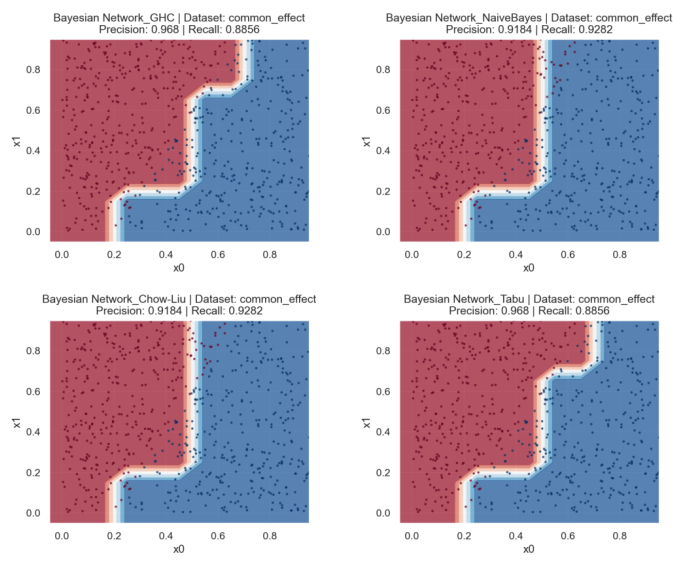

In [9]:
learn_methods = ["GHC", "NaiveBayes", "Chow-Liu", "Tabu" ]

# generate different BN classifiers from dataset using different structured learning methods
BNclfs, BNclfs_bn = util.generate_BNClassifiers( data_common_effect, learn_methods)
# show BN classifier learned structure
gnb.sideBySide(*BNclfs_bn, captions=learn_methods)
# visualize BN classifier decision boundary
util.visualize_BNDecisionBoundary(BNclfs)

### Generating Explanations

#### Investigating Conditional Independence

Explores all the CI between 2 variables and computes the p-values w.r.t to a csv file.

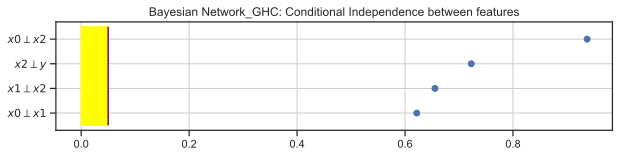

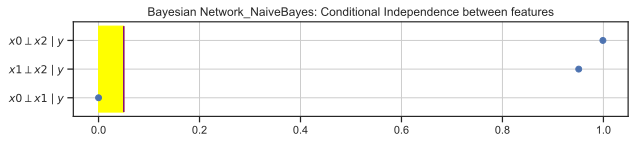

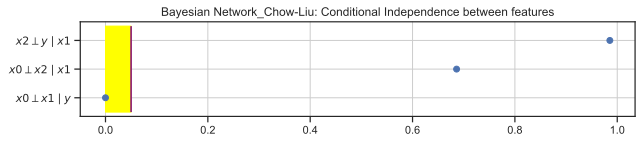

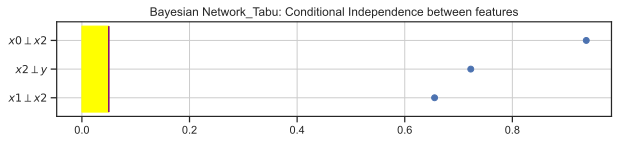

In [7]:
for i in range(0,len(BNclfs)):
  fig = expl.independenceListForPairs(BNclfs[i].clf.bn, vars.DATASET_PATH)
  plt.title( BNclfs[i].clf_name + ": Conditional Independence between features" )

The fisrt two classifiers (learning methods GHC and MIIC) correctly learned that all features are independent from each other. However, the Chow Liu network incorrectly learned a dependency between x0 and x1, because $x_0 \perp x_1~|~y = 0 $. The classifier that used the Tabu method failed to find independence between $x_1 \perp x_0$, however that does not seem to impact the model precision.


In [8]:
gnb.sideBySide(*BNclfs_bn, captions=learn_methods)

G <!-- x0 --> x0 x0 <!-- y --> y y <!-- x0->y --> x0->y <!-- x1 --> x1 x1 <!-- x1->y --> x1->y <!-- x2 --> x2 x2 GHC,G <!-- x0 --> x0 x0 <!-- x1 --> x1 x1 <!-- y --> y y <!-- y->x0 --> y->x0 <!-- y->x1 --> y->x1 <!-- x2 --> x2 x2 <!-- y->x2 --> y->x2 NaiveBayes,G <!-- x0 --> x0 x0 <!-- x1 --> x1 x1 <!-- x2 --> x2 x2 <!-- x1->x2 --> x1->x2 <!-- y --> y y <!-- y->x0 --> y->x0 <!-- y->x1 --> y->x1 Chow-Liu,G <!-- x0 --> x0 x0 <!-- x1 --> x1 x1 <!-- x0->x1 --> x0->x1 <!-- y --> y y <!-- y->x0 --> y->x0 <!-- y->x1 --> y->x1 <!-- x2 --> x2 x2 Tabu


#### Conditional SHAP values

Feature Importance in % for Bayesian Network_GHC
{'x0': 3.386836430030386, 'x1': 0.9596237988180474, 'x2': 0.0}
Feature Importance in % for Bayesian Network_NaiveBayes
{'x0': 3.364218486860285, 'x1': 0.47216040272887333, 'x2': 0.023567106532783412}
Feature Importance in % for Bayesian Network_Chow-Liu
{'x0': 3.364218486860285, 'x1': 0.47212955045361876, 'x2': 0.0034797656090092433}
Feature Importance in % for Bayesian Network_Tabu
{'x0': 3.784275428873331, 'x1': 0.952765251263724, 'x2': 4.1056047450638205e-17}


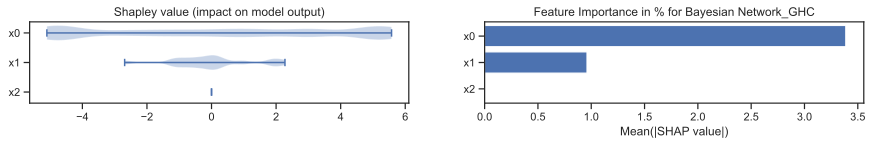

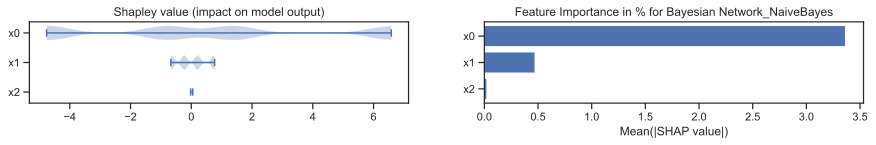

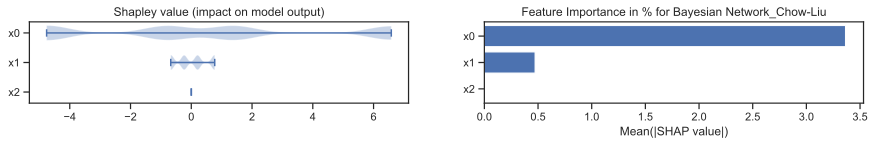

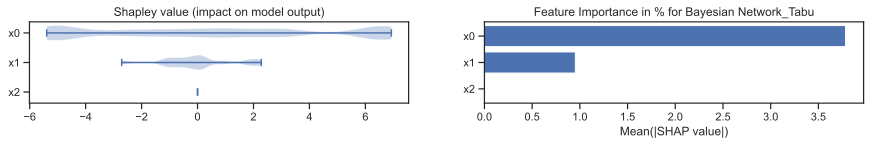

In [9]:
train = data_common_effect.dataset.sample(frac=1.0)
conditional_resshap = []
conditional_gumshap = []

for i in range(0, len(BNclfs)):
  gumshap = expl.ShapValues(BNclfs[i].clf.bn, 'y')
  result = gumshap.conditional(train, plot=True,plot_importance=True,percentage=False,)
  conditional_resshap.append(result)
  conditional_gumshap.append(gumshap)
  plt.title("Feature Importance in % for " + BNclfs[i].clf_name)
  plt.savefig(os.path.join(".","tmp", "shap", "conditional", data_common_effect.dataset_name + "_" + BNclfs[i].clf_name ) + ".png")
  print("Feature Importance in % for " + BNclfs[i].clf_name)
  print(result)

#### Marginal SHAP Values

Feature Importance in % for Bayesian Network_GHC
{'x0': 3.664357411249342, 'x1': 1.3261219902550612, 'x2': 0.0}
Feature Importance in % for Bayesian Network_NaiveBayes
{'x0': 3.366980649953748, 'x1': 0.474283877940416, 'x2': 0.025182810125145026}
Feature Importance in % for Bayesian Network_Chow-Liu
{'x0': 3.366980649953748, 'x1': 0.4742838779404127, 'x2': 1.1115182848205608e-17}
Feature Importance in % for Bayesian Network_Tabu
{'x0': 4.078416017275869, 'x1': 1.3261219902550614, 'x2': 5.631421255240361e-17}


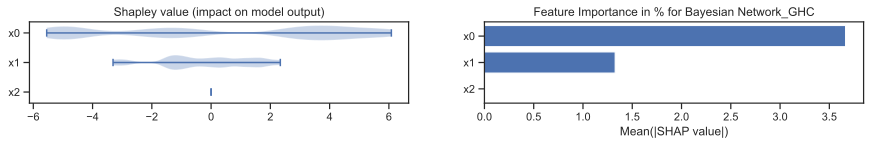

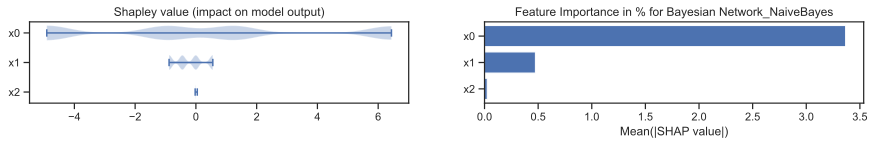

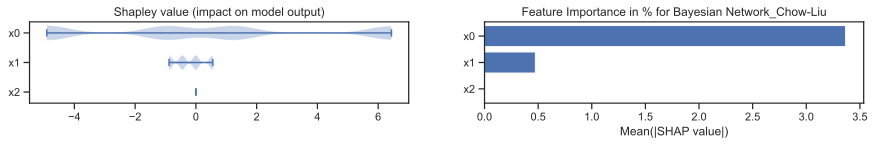

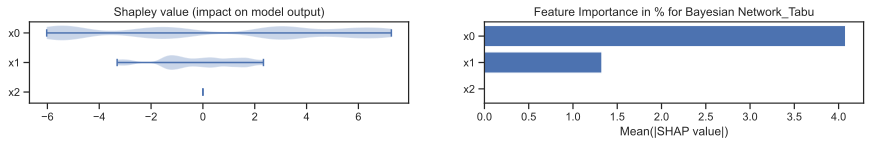

In [10]:
marginal_resshap = []
marginal_gumshap = []

for i in range(0, len(BNclfs)):
  gumshap = expl.ShapValues(BNclfs[i].clf.bn, 'y')
  marginal = gumshap.marginal(train, sample_size=10, plot=True,plot_importance=True,percentage=False)
  marginal_resshap.append(marginal)
  marginal_gumshap.append(gumshap)
  plt.title("Feature Importance in % for " + BNclfs[i].clf_name)
  plt.savefig(os.path.join(".","tmp", "shap", "marginal", data_common_effect.dataset_name + "_" + BNclfs[i].clf_name ) + ".png")
  print("Feature Importance in % for " + BNclfs[i].clf_name)
  print(marginal)

X2 is not part of the Markov Blanket and therefore its marginal contribution is null

#### Global Feature Importance with Kernel SHAP

[Bayesian Network_GHC] Expected Value: [0.41469822 0.58530178]


  0%|          | 0/10 [00:00<?, ?it/s]

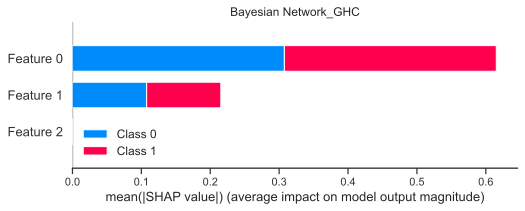

[Bayesian Network_NaiveBayes] Expected Value: [0.45728355 0.54271645]


  0%|          | 0/10 [00:00<?, ?it/s]

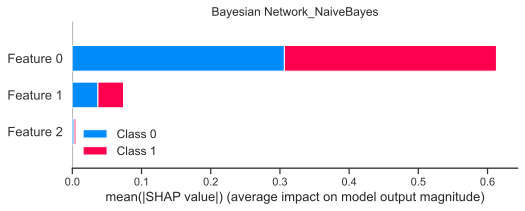

[Bayesian Network_Chow-Liu] Expected Value: [0.45679751 0.54320249]


  0%|          | 0/10 [00:00<?, ?it/s]

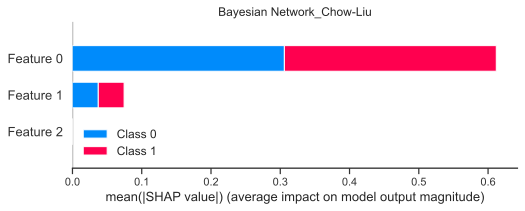

[Bayesian Network_Tabu] Expected Value: [0.41437548 0.58562452]


  0%|          | 0/10 [00:00<?, ?it/s]

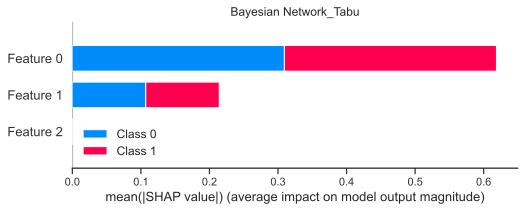

In [12]:
for clf in range(0,len(BNclfs)):
  explainer = shap.KernelExplainer(BNclfs[clf].clf.predict_proba, shap.sample(BNclfs[clf].Xtrain,10))
  expected_value = explainer.expected_value
  print("[" + BNclfs[clf].clf_name +"] "+ "Expected Value: " + str(expected_value))

  shap_values = explainer.shap_values(shap.sample(BNclfs[clf].Xtrain,10))
  plt.title(BNclfs[clf].clf_name)
  shap.summary_plot(shap_values, shap.sample(BNclfs[clf].Xtrain,10), plot_type="bar")


#### Visualize SHAP values in model

In [32]:
gumshap_viz = []
for i in range(0,len(conditional_resshap)):
  p = gumshap.showShapValues(results =conditional_resshap[i], cmap="RdBu")
  gumshap_viz.append( p )

gnb.sideBySide(*gumshap_viz, captions=learn_methods)


G <!-- x0 --> x0 x0 <!-- x1 --> x1 x1 <!-- x0->x1 --> x0->x1 <!-- y --> y y <!-- y->x0 --> y->x0 <!-- y->x1 --> y->x1 <!-- x2 --> x2 x2 GHC,G <!-- x0 --> x0 x0 <!-- x1 --> x1 x1 <!-- x0->x1 --> x0->x1 <!-- y --> y y <!-- y->x0 --> y->x0 <!-- y->x1 --> y->x1 <!-- x2 --> x2 x2 NaiveBayes,G <!-- x0 --> x0 x0 <!-- x1 --> x1 x1 <!-- x0->x1 --> x0->x1 <!-- y --> y y <!-- y->x0 --> y->x0 <!-- y->x1 --> y->x1 <!-- x2 --> x2 x2 Chow-Liu,G <!-- x0 --> x0 x0 <!-- x1 --> x1 x1 <!-- x0->x1 --> x0->x1 <!-- y --> y y <!-- y->x0 --> y->x0 <!-- y->x1 --> y->x1 <!-- x2 --> x2 x2 Tabu


In [23]:
infogain_viz = []
for model in BNclfs:
  p = expl.getInformation(model.clf.bn, cmap=plt.cm.RdBu )
  infogain_viz.append( p )

gnb.sideBySide(*infogain_viz, captions=learn_methods)

#### Generating Explanations using LIME

In [44]:
from  lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(BNclfs[0].Xtrain, feature_names=data_common_effect.feature_names, class_names=["Y:0", "Y:1"])

In [76]:
model = BNclfs[0]

exp = explainer.explain_instance(model.Xtest[0], model.clf.predict_proba, num_features=3 )
dict_base=dict(exp.as_map()[1])

for i in range(1,len(model.Xtest)):
    exp_next = explainer.explain_instance(model.Xtest[i], model.clf.predict_proba, num_features=3 )
    dict_next=dict(exp_next.as_map()[1])

    for key in dict_next.keys():
        if key in dict_base.keys():
            dict_base[key] = dict_next[key] + dict_base[key]
        else:
            print("SHIT!")
            pass
  
print(dict_base)

{0: -34.70678685892423, 1: 0.8315730890068914, 2: -0.1948412972228782}


### Generating Explanations for Neural Net


In [ ]:
from  lime.lime_tabular import LimeTabularExplainer
explainer_nn = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer_nn

In [ ]:
predict_fn = lambda x:  1.0 if nn.predict(x) >= 0.5 else 0.0

In [ ]:
indx = 5

instance1 =  np.expand_dims(X_test[indx], axis=0) 
instance2 =  X_test[indx]

exp = explainer.explain_instance(X_test[indx], nn.predict, num_features=3)
fig = exp.as_pyplot_figure()

In [ ]:
explainer_bn = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer_bn